In [1]:
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

In [2]:
rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

In [4]:
x = np.linspace(0,3,5)
x_p =x[:,None]
display(x,x_p)

array([0.  , 0.75, 1.5 , 2.25, 3.  ])

array([[0.  ],
       [0.75],
       [1.5 ],
       [2.25],
       [3.  ]])

### KRR
- $\alpha$:Small positive values of alpha improve the conditioning of the problem and reduce the variance of the estimates. Alpha corresponds to (2*C)^-1 in other linear models such as LogisticRegression or LinearSVC.
- $\gamma$:Gamma parameter for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels. 
- degree: Degree of the polynomial kernel. Ignored by other kernels.

In [22]:
# #############################################################################
# Fit regression model
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
# Exhaustive search over specified parameter values for an estimator.
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

SVR complexity and bandwidth selected and model fitted in 1.131 s
KRR complexity and bandwidth selected and model fitted in 0.644 s


In [16]:
krr = KernelRidge(kernel='rbf')
krr.fit(X[:train_size], y[:train_size])

<bound method BaseEstimator.get_params of KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)>

In [23]:
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))

Support vector ratio: 0.410
SVR prediction for 100000 inputs in 0.110 s
KRR prediction for 100000 inputs in 0.348 s


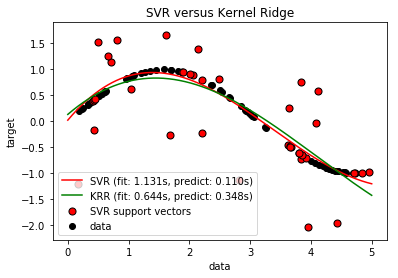

In [26]:
# #############################################################################
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend(loc='best')
plt.show()

In [28]:
# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
sizes = np.logspace(1, 4, 7, dtype=np.int)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

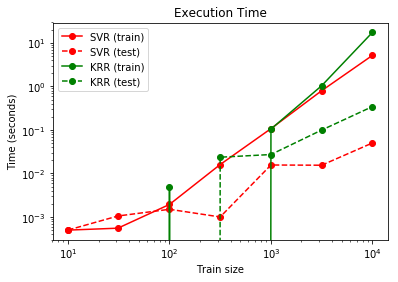

In [29]:
plt.show()

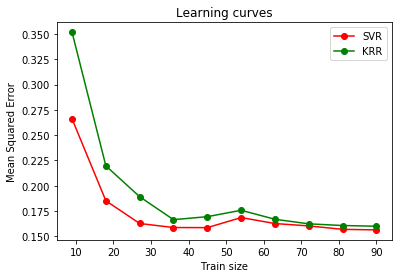

In [30]:
# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

In [32]:
import time

import numpy as np

import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

Time for KRR fitting: 10.176
Time for GPR fitting: 0.316
Time for KRR prediction: 0.073
Time for GPR prediction: 0.098
Time for GPR prediction with standard-deviation: 0.193


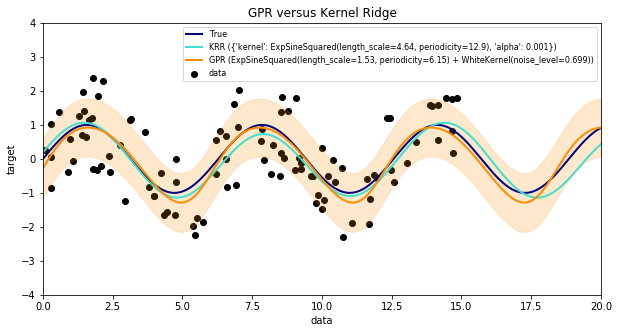

In [33]:
# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 20, 10000)[:, None]
stime = time.time()
y_kr = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using gaussian process regressor
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw,
         label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()